# data load

In [16]:
import pickle
import numpy as np
import pandas as pd
import sklearn
import lightgbm
import scipy
import bayes_opt
from matplotlib import pyplot as plt

In [2]:
# rawInfo=pd.read_csv('./dataset/[Track1_데이터1] mrc_info.csv',encoding='cp949')
# rawTrain=pd.read_csv('./dataset/[Track1_데이터2] samp_train.csv',encoding='cp949')
# rawCst=pd.read_csv('./dataset/[Track1_데이터3] samp_cst_feat.csv',encoding='cp949')
# rawDtype=pd.read_csv('./dataset/[Track1_데이터4] variable_dtype.csv',encoding='cp949')

In [3]:
# with open('./dataset/info.pkl','wb') as file:
#     pickle.dump(rawInfo,file)
    
# with open('./dataset/train.pkl','wb') as file:
#     pickle.dump(rawTrain,file)
    
# with open('./dataset/cst.pkl','wb') as file:
#     pickle.dump(rawCst,file)
    
# with open('./dataset/dtype.pkl','wb') as file:
#     pickle.dump(rawDtype,file)

In [2]:
with open('./dataset/info.pkl','rb') as file:
    info=pickle.load(file)
    
with open('./dataset/train.pkl','rb') as file:
    train=pickle.load(file)
    
with open('./dataset/cst.pkl','rb') as file:
    cst=pickle.load(file)
    
with open('./dataset/dtype.pkl','rb') as file:
    dtype=pickle.load(file)

# data browse


In [3]:
def datainfo(df):
    return pd.DataFrame([(col,df[col].nunique(),df[col].isna().sum(),df[col].dtype,df[col].unique()[:5]) for col in df.columns],
                       columns=['name','nunique','missing','dtype','value :5'])

In [6]:
# datainfo(info)
# datainfo(train)
# datainfo(cst)
# datainfo(dtype)

# data cleaning

In [7]:
# 0 미용 1 6 8 홈쇼핑 2 3 5 10 종합몰 4 9 전문몰 7 오픈마켓_소셜
# info

In [8]:
# 미용 대다수 그 뒤로 오픈마켓 홈쇼핑 등.
# train.MRC_ID_DI.value_counts(normalize=True)

In [4]:
# 숫자형 범주형 나누기
# dtype.dType.unique()
num_feature=dtype[dtype['dType']=='numerical'].Variable_Name.values
categorical_feature=list(dtype[dtype.dType=='categorical'].Variable_Name.values)

In [5]:
Train=pd.merge(train,cst,on=['cst_id_di'])
Train['MRC_ID_DI']=Train['MRC_ID_DI'].replace({1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1,10:1})

In [7]:
notFeature=['cst_id_di','MRC_ID_DI']
feature=[col for col in Train.columns if col not in notFeature]

X=Train[feature]
y=Train['MRC_ID_DI']

# binary baseline model

In [133]:
X_train,X_test,y_train,y_true=sklearn.model_selection.train_test_split(X,y,test_size=0.2,random_state=2020)

params={
    'objective':'binary',
    'metric':'binary_logloss',
    'is_unbalance':True,
    'learning_rate':0.03,
    'verbose':0    
}

In [134]:
cv=sklearn.model_selection.KFold(n_splits=6,shuffle=True,random_state=2020)
oof_train=dict()
models=[]

for foldId,(train_idx,valid_idx) in enumerate(cv.split(X_train)):
    X_tr,X_val=X_train.iloc[train_idx],X_train.iloc[valid_idx]
    y_tr,y_val=y_train.iloc[train_idx],y_train.iloc[valid_idx]

    lgbTrain=lightgbm.Dataset(X_tr,y_tr,categorical_feature=categorical_feature)
    lgbValid=lightgbm.Dataset(X_val,y_val,reference=lgbTrain,categorical_feature=categorical_feature)

    model=lightgbm.train(params,lgbTrain,num_boost_round=3000,valid_sets=[lgbValid],early_stopping_rounds=70,
                        verbose_eval=50,categorical_feature=categorical_feature)
    models.append(model)
    res=model.predict(X_test,num_iteration=model.best_iteration)
    
    oof_train[f"oof_{foldId}"]=res

Training until validation scores don't improve for 70 rounds
[50]	valid_0's binary_logloss: 0.381527
[100]	valid_0's binary_logloss: 0.37909
[150]	valid_0's binary_logloss: 0.364809
[200]	valid_0's binary_logloss: 0.352312
[250]	valid_0's binary_logloss: 0.344723
[300]	valid_0's binary_logloss: 0.338537
[350]	valid_0's binary_logloss: 0.334515
[400]	valid_0's binary_logloss: 0.330608
[450]	valid_0's binary_logloss: 0.329094
[500]	valid_0's binary_logloss: 0.327936
[550]	valid_0's binary_logloss: 0.327569
[600]	valid_0's binary_logloss: 0.32856
Early stopping, best iteration is:
[548]	valid_0's binary_logloss: 0.327387
Training until validation scores don't improve for 70 rounds
[50]	valid_0's binary_logloss: 0.393829
[100]	valid_0's binary_logloss: 0.397511
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.390028
Training until validation scores don't improve for 70 rounds
[50]	valid_0's binary_logloss: 0.390113
[100]	valid_0's binary_logloss: 0.388617
[150]	valid_0's

In [136]:
for model in models:
    print(f"best score :",model.best_score['valid_0']['binary_logloss'])

best score : 0.32738727236335946
best score : 0.390028415714558
best score : 0.35424345019003295
best score : 0.4148650630389748
best score : 0.3285707334818596
best score : 0.3855548399863246


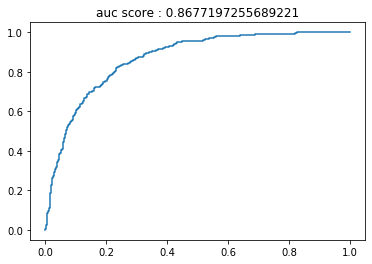

In [137]:
fpr,tpr,threshold=sklearn.metrics.roc_curve(y_true,oof_train['oof_0'])
auc=sklearn.metrics.roc_auc_score(y_true,oof_train['oof_0'])
plt.plot(fpr,tpr)
plt.title("auc score : "+str(auc))
plt.show()

In [141]:
pd.concat([pd.DataFrame(models[4].predict(X_test,raw_score=True)),y_true.reset_index(drop=True)],axis=1)
# 0.00268905598

,0,MRC_ID_DI
0,-6.221457,0
1,1.321056,0
2,-7.656170,0
3,-7.824752,0
4,2.445123,1
...,...,...
2020,1.567693,1
2021,-1.404259,0
2022,-0.747274,1
2023,1.041113,1


# hypertuning

In [261]:
def lgb_cv(learning_rate,max_depth,num_leaves,min_data_in_leaf,
              bagging_fraction,feature_fraction):
    params={
        'objective':'binary',
        'metric':'auc',
        'is_unbalance':True,
        'learning_rate':learning_rate,
        'max_depth':int(max_depth),
        'num_leaves':int(num_leaves),
        'min_data_in_leaf':int(min_data_in_leaf),
        'bagging_fraction':bagging_fraction,
        'feature_fraction':feature_fraction,
        'bagging_freq':0,
        'verbose':0    
    }
    
    lgbTrain=lightgbm.Dataset(X,y,categorical_feature=categorical_feature)
    
    res=lightgbm.cv(params,lgbTrain,num_boost_round=3000,verbose_eval=50,
                      categorical_feature=categorical_feature,nfold=6)
    
    return res['auc-mean']

def paramTuning(init_points,n_iter):
    lgbBO=bayes_opt.BayesianOptimization(lgb_train,{
        'learning_rate':(0.03,0.05),
        'max_depth':(6,10),
        'num_leaves':(300,500),
        'min_data_in_leaf':(50,90)
    },random_state=2020)
    lgbBO.maximize(init_points=init_points,n_iter=n_iter,acq='ei')
    return lgbBO

In [88]:
pred=models[4].predict(X,num_iteration=models[4].best_iteration)

In [262]:
best_params=paramTuning(2,7)

NameError: name 'bayes_opt' is not defined

In [94]:
sub=pd.concat([pd.DataFrame(pred),y],axis=1)
# sub['pred']=np.where(sub[0]<0.7)

In [491]:
import random 

n=random.randint(0,2020)

oof_train=pd.DataFrame()
params={
    'objective':'regression',
    'metric':'mape',
    'learning_rate':0.4115,
    'max_depth':int(9.433),
    'num_leaves':int(70.37),
    'min_data_in_leaf':int(354.1),
    'bagging_fraction':0.3,
    'feature_fraction':0.3,
    'verbose':0  
}


lgbTrain=lightgbm.Dataset(X,y,categorical_feature=categorical_feature)

model=lightgbm.train(params,lgbTrain,num_boost_round=3000,verbose_eval=50,categorical_feature=categorical_feature)
with open(f"./dataset/{n}_model.pkl", "wb") as file:
    pickle.dump(model, file)
    
pred=model.predict(X,num_iteration=model.best_iteration)

In [486]:
with open('./dataset/448_model.pkl','rb') as file:
    model=pickle.load(file)

In [492]:
pd.concat([y.reset_index(drop=True),round(pd.DataFrame(pred))],axis=1)

,MRC_ID_DI,0
0,4,4.0
1,2,2.0
2,4,4.0
3,1,1.0
4,2,2.0
...,...,...
10119,3,3.0
10120,4,4.0
10121,4,4.0
10122,4,4.0
